# RNN - Model

In [10]:
# DATA MANIPULATION, Visualization, and stats
import pandas as pd
from glob import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [11]:
# Your current working directory should be ./mattwagon/oil_production_prediction/notebooks
os.getcwd()

'/Users/eduardomonteiro/code/mattwagon/oil_production_prediction/notebooks'

## Import the data

In [12]:
# This filepath should work for all of us
# I have added 'raw_data' to .gitignore so it should never be pushed to the repo
path = os.path.join('..', 'raw_data')
file_names = os.listdir(path)
csv_files = [f for f in file_names if f.endswith('.csv')]

csv_files.sort()

df = pd.DataFrame()

for file in csv_files:
    file_path = os.path.join(path, file)
    df_aux = pd.read_csv(file_path)
    df = pd.concat([df, df_aux], ignore_index=True)

In [13]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.tz_convert(None)
df['Date'] = pd.to_datetime(df['Date'].apply(lambda x: x + pd.DateOffset(hours=1)))

In [14]:
df.head()

,Date,Calculated Drawdown_At Gauge,Calculated Drawdown_At Bottom Node,Reservoir Pressure,z Well Identifier,z TMore PS Identifier,z TMore Identifier,z Tag Identifier 2,z Tag Identifier,z PI-AF Database,...,Annulus Master Valve Status,Annulus Master Valve Opening Frequency,Pseudo Cv,GL GOR,GL Qgas,GL Qliq,GL Qoil,GL Qwat,GL Ramp-up Speed,GL WCT
0,2007-02-01,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
1,2007-02-02,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
2,2007-02-03,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
3,2007-02-04,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
4,2007-02-05,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08


## Data cleaning

### Drop features with more than 30% NaN values

In [15]:
features_nan_drop = []

for feature, value in dict(df.isnull().sum().sort_values(ascending=False)).items():
    if value/len(df) > 0.3:
        features_nan_drop.append(feature)
        
df.drop(columns=features_nan_drop, inplace=True)

In [16]:
df.shape

(5813, 65)

### Drop features with std = 0

In [17]:
features_null_std = []

for feature in df.drop(columns='Date').columns:
    if df[feature].std() < 0.0000001:
        features_null_std.append(feature)
        
df.drop(columns=features_null_std, inplace=True)

In [18]:
df.shape

(5813, 41)

### Drop corrected features

In [19]:
corrected_features_drop = ['Qwat MPFM corrected', 'Qoil MPFM corrected', 'Qliq MPFM corrected', 'Qgas MPFM corrected']
df.drop(columns=corrected_features_drop, inplace=True)

### Drop choke features

In [20]:
choke_features_drop = ['Choke Opening Calc1', 'Choke Opening Calc2', 'Choke Measured', 'Choke Calculated', 'Choke CCR']
df.drop(columns=choke_features_drop, inplace = True)

### Drop correlated features

In [21]:
features_corr_drop = ['Qwat PC', 'Qgas PC', 'Qoil PC', 'Tubing dP','MPFM P', 'Qliq MPFM', 'Qwat MPFM']
df.drop(columns=features_corr_drop, inplace = True)

### Drop features in remove dictionary

In [22]:
remove = {"Sand Rate", "MPFM NTotal Count Rate", "MPFM N81 Count Rate", "MPFM N356 Count Rate", "MPFM N32 Count Rate", "MPFM GOR", "Downhole Gauge T", "Downhole Gauge P"}

In [23]:
df.drop(columns=remove, inplace=True)

### Drop the Date

In [24]:
df.drop(columns='Date', inplace=True)

## Impute features with <30% NaN values

In [25]:
for feature in df.columns:
    df[feature].replace(np.nan, df[feature].median(), inplace=True)

In [26]:
df.isnull().sum()

WHT                0
WHP                0
Tubing Gradient    0
Service Line P     0
Sand Raw           0
Qoil MPFM          0
Qgas MPFM          0
MPFM WCT           0
MPFM Venturi dP    0
MPFM T             0
MPFM CF GOR        0
Manifold T         0
Manifold P         0
Jumper T           0
Choke Opening      0
Annulus P          0
dtype: int64

## Visualising the Time Series

In [62]:
TARGET = 'Qoil MPFM'
N_TARGETS = 1
N_FEATURES = 3 

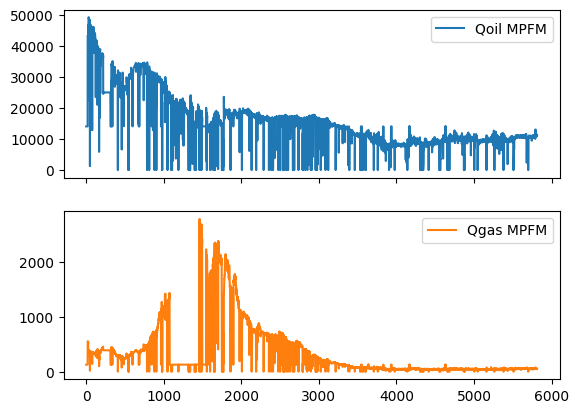

In [61]:
plot_cols = [TARGET, 'Qgas MPFM']
plot_features = df[plot_cols]
plot_features.index = df.index
plot_features.plot(subplots = True);

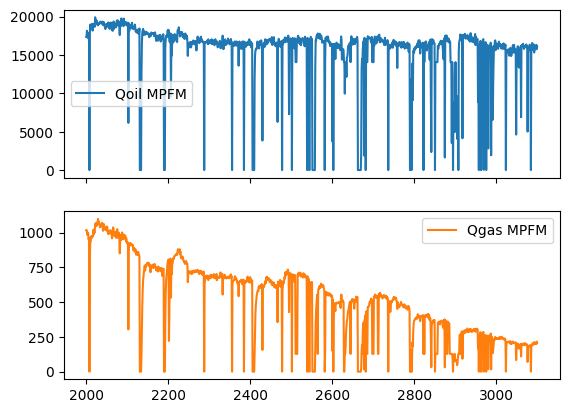

In [63]:
zoomed_slice = slice(2000,3100)

plot_features = df.loc[zoomed_slice, plot_cols]
plot_features.plot(subplots = True);

## Prepare the dataset

### The big picture

Step 1: Cross validation in time series (folds):
    - we'll create folds and train/evaluate our LSTM on these different folds about the robustness of the neural network

Step 2: Holdout method within each fold (train-test-split) to:
    - fit the model on the train set;
    - and evaluate it on the test set;
    - always split the train set chronologically before the test set
    
Step 3: Sampling sequences in both the train set and the test set

### Creating folds for cross-validation

In [72]:
df_LSTM = df[['MPFM Venturi dP', 'WHT', 'Qoil MPFM']]
df_LSTM

,MPFM Venturi dP,WHT,Qoil MPFM
0,1672.997986,51.247467,14065.431937
1,1672.997986,51.247467,14065.431937
2,1672.997986,51.247467,14065.431937
3,1672.997986,51.247467,14065.431937
4,1672.997986,51.247467,14065.431937
...,...,...,...
5808,1687.935181,51.966740,10925.670806
5809,1719.284912,51.968021,11142.564473
5810,1742.380127,51.972717,11140.120568
5811,1729.632324,51.982071,11400.139595


In [73]:
# --------------------------------------------------- #
# Let's consider FOLDS with a length of 3 years       #
# (2 years will be used for train, 1 for test!)       #
# --------------------------------------------------- #

FOLD_LENGTH = 365 * 6 # six years

# --------------------------------------------------- #
# Let's consider FOLDS starting every trimester       #
# --------------------------------------------------- #
    
FOLD_STRIDE = 91 # 1 quarter = 91 days

# --------------------------------------------------- #
# Let's consider a train-test-split ratio of 2/3      #
# --------------------------------------------------- #

TRAIN_TEST_RATIO = 0.66

In [74]:
def get_folds(
    df: pd.DataFrame,
    fold_length: int,
    fold_stride: int) -> list[pd.DataFrame]:
    '''
    This function slides through the Time Series dataframe of shape (n_timesteps, n_features) to create folds
    - of equal `fold_length`
    - using `fold_stride` between each fold
    
    Returns a list of folds, each as a DataFrame
    '''
    fold_list = []
    
    
    for i in range(0, len(df), fold_stride):
        if i + fold_length >= len(df):
            break
        fold_list.append(df[i:fold_length])
    
    return fold_list

In [75]:
folds = get_folds(df_LSTM, FOLD_LENGTH, FOLD_STRIDE)

print(f'The function generated {len(folds)} folds.')
print(f'Each fold has a shape equal to {folds[0].shape}.')

The function generated 40 folds.
Each fold has a shape equal to (2190, 3).


### Temporal Train/Test Split

Focus on 1 fold for the moment:

In [76]:
fold = folds[0]
fold

,MPFM Venturi dP,WHT,Qoil MPFM
0,1672.997986,51.247467,14065.431937
1,1672.997986,51.247467,14065.431937
2,1672.997986,51.247467,14065.431937
3,1672.997986,51.247467,14065.431937
4,1672.997986,51.247467,14065.431937
...,...,...,...
2185,4440.488770,50.234428,17033.866361
2186,4339.430664,50.448097,17049.719495
2187,4462.657715,50.312836,17144.442110
2188,4526.409668,50.242947,17705.125916


Split the fold above chronologically into a train dataframe and a test dataframe

In [122]:
INPUT_LENGTH = 14 #two weeks

In [123]:
def train_test_split(fold:pd.DataFrame,
                     train_test_ratio: float,
                     input_length: int) -> tuple[pd.DataFrame]:
    '''
    Returns a train dataframe and a test dataframe (fold_train, fold_test)
    from which one can sample (X,y) sequences.
    df_train should contain all the timesteps until round(train_test_ratio * len(fold))   
    '''
    fold_train = fold[0: round(train_test_ratio * len(fold))]
    fold_test = fold[round(train_test_ratio * len(fold)) - input_length:]
    
    return fold_train, fold_test

In [124]:
(fold_train, fold_test) = train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH)

### Create (X,y) sequences

In [125]:
# INPUT X
print(f'N_FEATURES = {N_FEATURES}')
print(f'INPUT_LENGTH = {INPUT_LENGTH} days = {int(INPUT_LENGTH/7)} weeks')

N_FEATURES = 3
INPUT_LENGTH = 14 days = 2 weeks


In [126]:
# TARGET Y
print(f'N_TARGETS = {N_TARGETS}')

# Let's only predict 1 value ahead of us
OUTPUT_LENGTH = 1
print(f'OUTPUT_LENGTH = {OUTPUT_LENGTH}')

N_TARGETS = 1
OUTPUT_LENGTH = 1


In [127]:
def get_Xi_yi(
    fold:pd.DataFrame, 
    input_length:int, 
    output_length:int):
    '''
    - given a fold, it returns one sequence (X_i, y_i)
    - with the starting point of the sequence being chosen at random
    '''
    random_number = np.random.randint(0,len(fold) - (input_length + output_length) + 1)

    X_i = fold.iloc[random_number : random_number + input_length]
    y_i = fold.iloc[random_number + input_length : random_number + input_length + output_length][[TARGET]]
    
    return (X_i, y_i)

In [128]:
X_train_i, y_train_i = get_Xi_yi(fold_train, INPUT_LENGTH, OUTPUT_LENGTH)
X_test_i, y_test_i = get_Xi_yi(fold_test, INPUT_LENGTH, OUTPUT_LENGTH)

In [129]:
# Advanced check 😈 
# You should not allow some truncated (X_i,y_i) pairs to be generating,
# should you start sampling too close from the end of the fold... !

X_last, y_last = get_Xi_yi(fold_test, input_length=len(fold_test)-1, output_length=OUTPUT_LENGTH)
assert y_last.values == fold_test.iloc[-1,:][TARGET]

In [130]:
X_train_i.shape

(14, 3)

### Scanning chronologically

Let's scan the fold with a temporal stride of 1 day (the minimum one)

In [131]:
SEQUENCE_STRIDE = 1

In [132]:
def get_X_y_strides(fold: pd.DataFrame, input_length: int, output_length: int, sequence_stride: int):
    '''
    - slides through a `fold` Time Series (2D array) to create sequences of equal
        * `input_length` for X,
        * `output_length` for y,
    using a temporal gap `sequence_stride` between each sequence
    - returns a list of sequences, each as a 2D-array time series
    '''

    X, y = [], []

    for i in range(0, len(fold), sequence_stride):
        # Exits the loop as soon as the last fold index would exceed the last index
        if (i + input_length + output_length) >= len(fold):
            break
        X_i = fold.iloc[i:i + input_length, :]
        y_i = fold.iloc[i + input_length:i + input_length + output_length, :][[TARGET]]
        X.append(X_i)
        y.append(y_i)

    return np.array(X), np.array(y)

In [133]:
print("FOLD_LENGTH") 
print(f"= {int(FOLD_LENGTH)} days")
print(f"= {int(FOLD_LENGTH/7)} weeks")

FOLD_LENGTH
= 2190 days
= 312 weeks


In [134]:
X_train, y_train = get_X_y_strides(fold_train, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
X_test, y_test = get_X_y_strides(fold_test, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)

print(X_train.shape)
print(y_train.shape)

(1430, 14, 3)
(1430, 1, 1)


## Modeling

### LSTM

Create a function init_model which builds and compiles a simple Recurrent Neural Network with an LSTM layer

In [135]:
X_train.shape

(1430, 14, 3)

In [136]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.layers import Normalization

In [137]:
def init_model(X_train, y_train):
    
    #normalization
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    #arquitecture
    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.LSTM(64, activation='tanh', kernel_regularizer=L1L2(l1=0.05, l2=0.05)))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.02)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [138]:
model = init_model(X_train, y_train)
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, None, 3)          7         
 ion)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 64)                17408     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 17,480
Trainable params: 17,473
Non-trainable params: 7
_________________________________________________________________


In [139]:
def plot_history(history):
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: MSE --- 
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- METRICS:MAE ---
    
    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
                        
    return ax

In [140]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=5, restore_best_weights=True)

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=32,
                        epochs=100,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [141]:
model, history = fit_model(model)

Epoch 1/100
32/32 [==============================] - 1s 14ms/step - loss: 999141696.0000 - mae: 30791.7480 - val_loss: 370192896.0000 - val_mae: 17719.9238
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 996532736.0000 - mae: 30750.1367 - val_loss: 367659136.0000 - val_mae: 17658.4180
Epoch 3/100
32/32 [==============================] - 0s 3ms/step - loss: 993950784.0000 - mae: 30708.9492 - val_loss: 366582272.0000 - val_mae: 17634.7773
Epoch 4/100
32/32 [==============================] - 0s 3ms/step - loss: 991407616.0000 - mae: 30668.3418 - val_loss: 365358336.0000 - val_mae: 17606.9102
Epoch 5/100
32/32 [==============================] - 0s 3ms/step - loss: 988898112.0000 - mae: 30628.2266 - val_loss: 364199328.0000 - val_mae: 17581.0273
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 986371008.0000 - mae: 30587.7500 - val_loss: 363159008.0000 - val_mae: 17558.4023
Epoch 7/100
32/32 [==============================] - 0s 3ms/step - lo

32/32 [==============================] - 0s 3ms/step - loss: 874622528.0000 - mae: 28742.0723 - val_loss: 314078336.0000 - val_mae: 16406.9902
Epoch 54/100
32/32 [==============================] - 0s 3ms/step - loss: 872360192.0000 - mae: 28703.4961 - val_loss: 313115712.0000 - val_mae: 16383.4404
Epoch 55/100
32/32 [==============================] - 0s 3ms/step - loss: 870101888.0000 - mae: 28664.9355 - val_loss: 312157152.0000 - val_mae: 16359.9570
Epoch 56/100
32/32 [==============================] - 0s 3ms/step - loss: 867847744.0000 - mae: 28626.3887 - val_loss: 311202464.0000 - val_mae: 16336.5488
Epoch 57/100
32/32 [==============================] - 0s 3ms/step - loss: 865597504.0000 - mae: 28587.8652 - val_loss: 310255328.0000 - val_mae: 16313.3662
Epoch 58/100
32/32 [==============================] - 0s 3ms/step - loss: 863351360.0000 - mae: 28549.3555 - val_loss: 309323104.0000 - val_mae: 16290.6768
Epoch 59/100
32/32 [==============================] - 0s 4ms/step - loss: 861

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

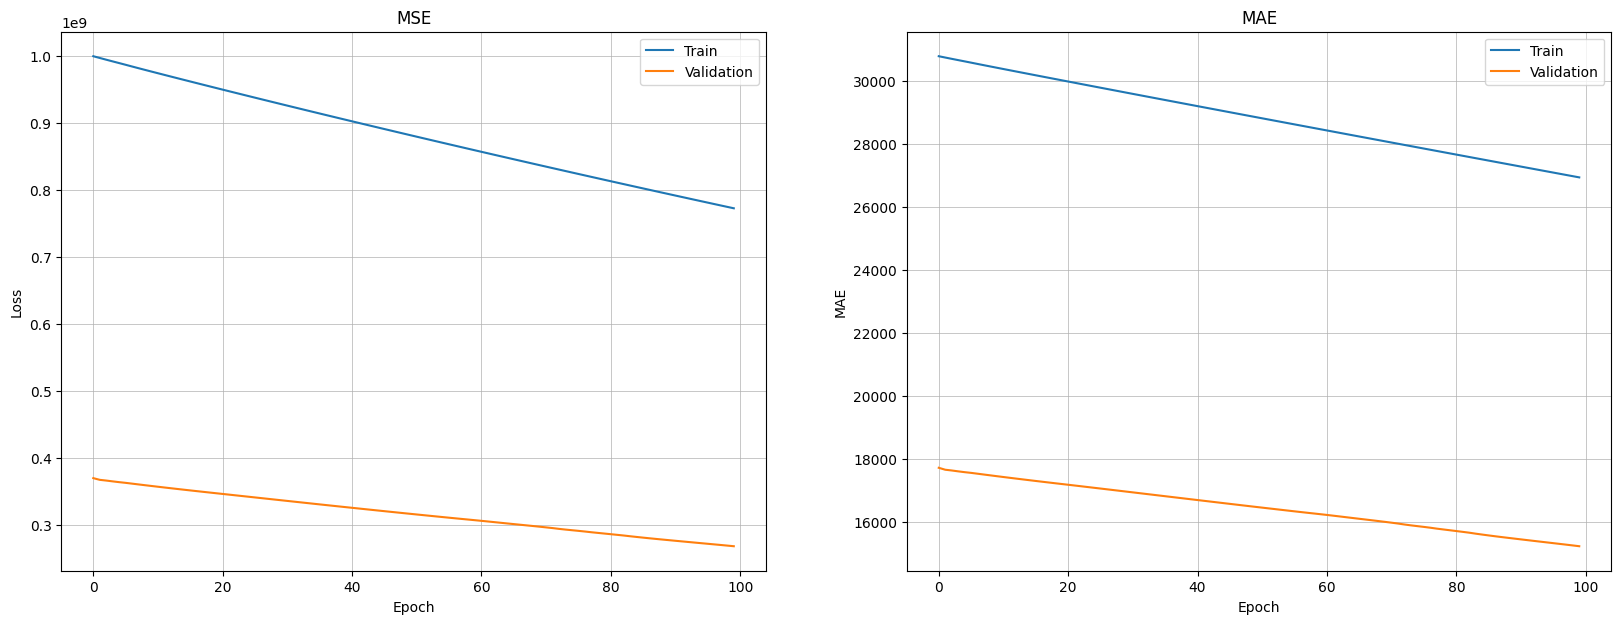

In [142]:
plot_history(history)

In [143]:
res = model.evaluate(X_test, y_test, verbose=0)
res

[200912800.0, 13649.931640625]

### Baseline Model

In [144]:
from tensorflow.keras.layers import Lambda

def init_baseline():

    model = models.Sequential()
    model.add(Lambda(lambda x: x[:, -1, 1, None]))
    
    adam = optimizers.Adam(learning_rate = 0.02)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [145]:
baseline_model = init_baseline()
baseline_score = baseline_model.evaluate(X_test, y_test)
print(f"- The Baseline MAE on the test set is equal to {round(baseline_score[1],2)} m3")

24/24 [==============================] - 0s 354us/step - loss: 276075424.0000 - mae: 15974.0498
- The Baseline MAE on the test set is equal to 15974.05 m3
